In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import stitch
import utils
import features

In [2]:
def convertResult(img):
    '''Because of your images which were loaded by opencv, 
    in order to display the correct output with matplotlib, 
    you need to reduce the range of your floating point image from [0,255] to [0,1] 
    and converting the image from BGR to RGB:'''
    img = np.array(img,dtype=float)/float(255)
    img = img[:,:,::-1]
    return img

In [3]:
#load images
list_images=utils.loadImages(r'C:\Users\yl\Desktop\sucai\cd',resize=0)

zhtux1 = cv2.imread(r"C:\Users\yl\Desktop\sucai\TDMovieOut.2 (1).jpg")
zhtux2 = cv2.imread(r"C:\Users\yl\Desktop\sucai\TDMovieOut.2 (1).jpg")


In [6]:
#wrap 2 image
#choose list_images[0] as desination
pano,non_blend,left_side,right_side=stitch.warpTwoImages(list_images[1],list_images[0],True)

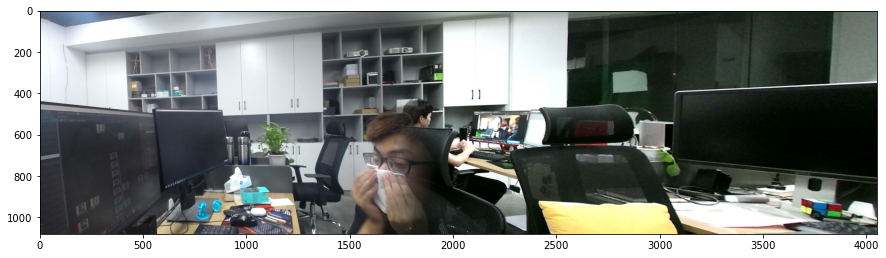

In [7]:
#pano after cropping and blending
plt.figure(figsize=(15,15))
plt.imshow(convertResult(pano))

In [8]:
src_img = list_images[1]
dst_img = list_images[0]

In [9]:
#    --------------------warpTwoImages(src_img, dst_img, showstep=False) ---------------------
# generate Homography matrix
#   #   H, _ = features.generateHomography(src_img, dst_img)

H, _ = features.generateHomography(src_img, dst_img)


# get height and width of two images 获得图像高宽
height_src, width_src = src_img.shape[:2]
height_dst, width_dst = dst_img.shape[:2]

# extract conners of two images: top-left, bottom-left, bottom-right, top-right
pts1 = np.float32(
    [[0, 0], [0, height_src], [width_src, height_src], [width_src, 0]]
).reshape(-1, 1, 2)
pts2 = np.float32(
    [[0, 0], [0, height_dst], [width_dst, height_dst], [width_dst, 0]]
).reshape(-1, 1, 2)


In [13]:
print(type(pts1),type(pts2),pts1.shape,pts2.shape,pts1,pts2)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (4, 1, 2) (4, 1, 2) [[[   0.    0.]]

 [[   0. 1080.]]

 [[1920. 1080.]]

 [[1920.    0.]]] [[[   0.    0.]]

 [[   0. 1080.]]

 [[1920. 1080.]]

 [[1920.    0.]]]


In [14]:
# Opencv 投射变换代码 Dst x,y,z为变化过后的坐标 = Src x,y,z为变换签坐标 * H为投射矩阵
pts1_ = cv2.perspectiveTransform(pts1, H)

In [15]:
pts = np.concatenate((pts1_, pts2), axis=0) # 拼接成一个 ([1,2,3]) ({4,5,6}) = ([1,2,3,4,5,6])

In [17]:
print(type(pts),pts.shape,pts,)

<class 'numpy.ndarray'> (8, 1, 2) [[[  715.8265     -38.931038]]

 [[  784.41516    932.9152  ]]

 [[ 4050.4717    1441.0687  ]]

 [[ 4453.744    -1047.1964  ]]

 [[    0.           0.      ]]

 [[    0.        1080.      ]]

 [[ 1920.        1080.      ]]

 [[ 1920.           0.      ]]]


In [18]:
# 求x,y坐标的最大值和最小值
[xmin, ymin] = np.int64(pts.min(axis=0).ravel() - 0.5)

In [19]:
print(xmin, ymin)

0 -1047


In [20]:
[_, ymax] = np.int64(pts.max(axis=0).ravel() + 0.5)
t = [-xmin, -ymin]
print(_, ymax)
print(t)

4454 1441
[0, 1047]


In [22]:
#应用单应矩阵的图像左上角点，该图像具有x坐标&lt;0,还有一面=
# 否则边=对吧
#源图像合并到目标图像的左边或右边  width_dst 1920
if pts[0][0][0] < 0:
    side = "left"
    width_pano = width_dst + t[0]
else:
    width_pano = int(pts1_[3][0][0])
    side = "right"
height_pano = ymax - ymin
print("side",side)
print("width_pano",width_pano)
print("height_pano",height_pano,ymax,ymin)

side right
width_pano 4453 1920 0
height_pano 2488 1441 -1047


In [23]:
Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
print(type(Ht),Ht)

<class 'numpy.ndarray'> [[   1    0    0]
 [   0    1 1047]
 [   0    0    1]]


In [ ]:
src_img_warped = cv2.warpPerspective(
    src_img, Ht.dot(H), (width_pano, height_pano)
)